In [ ]:
# default_exp model

In [ ]:
# export
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data import *

from ipywidgets import widgets
from sklearn.neighbors import NearestNeighbors
import umap
import seaborn as sns
from sklearn.decomposition import PCA

#!conda install -c conda-forge umap-learn 

In [ ]:
#hide
from nbdev.showdoc import *

# first snkrfinder.model a



## OVERVIEW: model module- MobileNet_v2 feature extractor

This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

Feature extractor: 
    1. embed database into feature space.
    2. evaluate/validate by simple logistic regression on classification.




## A: MobileNet_v2 as feature extractor


## B: add ResNet and expand modeling
embed database into feature space.
evaluate by simple logistic regression on classification.

NOTE:  symbolic link in the nbs directory to enable the module loads in these notebooks.  i.e. `ln -s ../snkrfinder/ snkrfinder`

# Part 2: tune MobileNet_v2 feature extractor to my space

In [ ]:
#hide
print(fastai.__version__)

2.2.5


In [ ]:
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkr-finder/nbs
/home/ergonyc/Projects/Project2.0/snkr-finder


In [ ]:
# hide
# this should go into a utils or cfg module
HOME = get_home()

In [ ]:
# hide

path_images = D_ROOT/'ut-zap50k-images'

IMG_SIZE,path_images,D_ROOT,DBS['zappos']

(160,
 Path('/home/ergonyc/Projects/DATABASE/ut-zap50k-images'),
 Path('/home/ergonyc/Projects/DATABASE'),
 '/ut-zap50k-images')

In [ ]:

filename = ZAPPOS_DF_SIMPLIFIED # "zappos-50k-simplified"
df = pd.read_pickle(f"data/{filename}.pkl")

##  mobilenet v2

We will use Google's mobileNetV2 trained on ImageNet loaded from torchvision to embed our sneakers into a feature space.  

### decapitate mobilnet_v2 (neuter)

Because we simply want to collect the _features_ output from the model rather than do classification (or some other decision) I replaced the clasiffier _head_ with a simple identity mapper.   The simple Identity nn.Module class makes this simple.

Finally, since we are calculating the features, or _embedding_ over 30k images with the net lets load the computations onto our GPU.  We need to remember to do this in evaluation mode so Batch Norm / Dropout layers are disabled.  [I forgot to do this initally and lost hours trying to figure out why i wasn't getting consistent results]. Setting `param.requires_grad = False` saves us memory since we aren't going to fit any weights for now, and protects us in case we forget to do a `with torch.no_grad()` before inference.

Later when we use the full FastAI API this should all be handled elegantly behind the scenes

In [ ]:
# export

# these are pure torch wrappers... should replace with fastai calls.
def get_cuda():
    """ try to load onto GPU""" 
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
def get_cpu():
    """
    set device to cpu.
    """
    return torch.device("cpu")

In [ ]:
# hide

# ### NOTE: these are from https://walkwithfastai.com/Style_Transfer

# # these are the convlayer "features" to define style for styletransfer
# _vgg_config = {
#     'vgg16' : [1, 11, 18, 25, 20],
#     'vgg19' : [1, 6, 11, 20, 29, 22]
# }

# from torchvision.models import vgg19, vgg16

# feat_net = vgg19(pretrained=True).features.cuda().eval()

# def get_feats(arch:str, pretrained=True):
#     "Get the features of an architecture"
#     feat_net, layers = _get_layers(arch, pretrained)
#     hooks = hook_outputs(layers, detach=False)
#     def _inner(x):
#         feat_net(x)
#         return hooks.stored
#     return _inner



# def _get_layers(arch:str, pretrained=True):
#     "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
#     feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
#     config = _vgg_config.get(arch)
#     features = feat_net.features.cuda().eval()
#     for p in features.parameters(): p.requires_grad=False
#     return feat_net, [features[i] for i in config]



# feats = get_feats('vgg19')


In [ ]:
#export

def get_mnetV2_feature_net(to_cuda=False):    
    # use fastai builtin Identity
    #     ## use an "identity" layer to replace 1000 category classifier
    #     class Identity(nn.Module):
    #         def __init__(self):
    #             super(Identity, self).__init__()

    #         def forward(self, x):
    #             return x
    
    mnetv2  = torchvision.models.mobilenet_v2(pretrained=True)    
    mnetv2.classifier = Identity()
    
    if to_cuda:
        device = get_cuda()
    else:
        device = get_cpu()

    mnetv2 = mnetv2.to(device)
    mnetv2.eval()  # force it to eval mode to turn off batchnorm/dropout

    # just incase we forget the no_grad()
    for param in mnetv2.parameters():
        param.requires_grad = False
        
    return mnetv2

In [ ]:
# export

def get_feats_dataloaders(data,batch_size, size, device):
    # put everythign in train, and don't do any augmentation since we are just going 
    # resize to 224
    # set up the helper functions to pass data into the
    def get_x(r): return path_images/r['path']
    #def get_y(r): return r['Category']  # we aren't actually using the category here (see 02_model.ipynb)
    def get_fname(r): return r['path']

    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_fname,
                   item_tfms=Resize(size, method='pad', pad_mode='border'),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))  # border pads white...
    dls = dblock.dataloaders(data,bs=batch_size,drop_last=False,device=device)
    #since we are just calculating the features for all the data turn off shuffling
    dls.train.shuffle=False
    return dls


In [ ]:
# hide 


# outs = []
# inps = []
# dl = learner.dls.test_dl(imgs)
# learn.model.eval()
# with torch.no_grad():
#   for batch in dl:
#     outs.append(learner.model(batch[0]))
#     inps.append(batch[0])

# outs = torch.stack(outs)
# inps = torch.stack(inps)
# dec = learner.dls.decode_batch((*tuplify(inps), *tuplify(outs)))



# type_tfms = [PILImage.create]
# item_tfms = [Resize(224), ToTensor()]
# type_pipe = Pipeline(type_tfms)
# item_pipe = Pipeline(item_tfms)
# norm = Normalize.from_stats(*imagenet_stats)
# i2f = IntToFloatTensor()


# batches = []
# batch = []
# outs = []
# inps = []
# k = 0
# for im in im_names:
#     batch.append(item_pipe(type_pipe(im)))
#     k += 1
#     if k == 50:
#         batches.append(torch.cat([norm(i2f(b.cuda())) for b in batch]))
#         batch = []
#         k = 0

# learner.model.eval()
# with torch.no_grad():
#     for b in batches:
#         outs.append(learner.model(b))
#         inps.append(b)

# inp = torch.stack(inps)
# out = torch.stack(outs)
# dec = learner.dls.decode_batch((*tuplify(inp), *tuplify(out)))
   
    
    
# def get_all_feats1(files,model,to_df=False):
# type_tfms = [PILImage.create]
# item_tfms = [Resize(224), ToTensor()]
# type_pipe = Pipeline(type_tfms)
# item_pipe = Pipeline(item_tfms)
# norm = Normalize.from_stats(*imagenet_stats)
# i2f = IntToFloatTensor()


# batches = []
# batch = []
# outs = []
# inps = []
# k = 0
# for im in im_names:
#     batch.append(item_pipe(type_pipe(im)))
#     k += 1
#     if k == 50:
#         batches.append(torch.cat([norm(i2f(b.cuda())) for b in batch]))
#         batch = []
#         k = 0

# learner.model.eval()
# with torch.no_grad():
#     for b in batches:
#         outs.append(learner.model(b))
#         inps.append(b)

# inp = torch.stack(inps)
# out = torch.stack(outs)
# dec = learner.dls.decode_batch((*tuplify(inp), *tuplify(out)))

#     #type_tfms = [PILImage.create]
#     item_tfms = [Resize(IMG_SIZE, method='pad', pad_mode='border'), ToTensor()]
#     #type_pipe = Pipeline(type_tfms)
#     item_pipe = Pipeline(item_tfms)
#     norm = Normalize.from_stats(*imagenet_stats)
#     i2f = IntToFloatTensor()

#     batches = []
#     batch = []
#     outs = []
#     inps = []
#     k = 0
#     for im in im_names:
#         batch.append(item_pipe(type_pipe(im)))
#         k += 1
#         if k == 50:
#             batches.append(torch.cat([norm(i2f(b.cuda())) for b in batch]))
#             batch = []
#             k = 0

#     model.eval()
#     with torch.no_grad():
#         for b in batches:
#             outs.append(model(b))
#             #inps.append(b)

#     out = torch.stack(outs)
#     #inps = torch.stack(inps)
#     if to_df:
#         # need to detach... TODO
#         return pd.DataFrame({"path": paths, "classes":clss, "features":vects})

#     return outs



In [ ]:
#export


def get_all_feats0(dls,model,to_df=False):
    " expect dls to give us sorted (alphabetical)"
    outs = []
    clss = []
    paths = []
    batchn = 0


    with torch.no_grad():
        for imgs,classes in dls.train:
            outs.extend(conv_net(imgs))
            clss.extend(classes)
            paths.extend( [dls[0].vocab[c] for c in classes])
            batchn += 1

    #inps = torch.stack(inps)
    if to_df:
        out = np.stack(to_detach(outs))
        cs = np.stack(to_detach(clss))
        fn = np.stack(paths)
        return pd.DataFrame({"path": fn, "classes":cs, "features":out})

    return outs

def get_all_feats(dls,conv_net):
    outs = []
    clss = []
    paths = []
    batchn = 0


    with torch.no_grad():
        for imgs,classes in dls.train:
            outs.extend(conv_net(imgs))
            clss.extend(classes)
            paths.extend( [dls[0].vocab[c] for c in classes])
            batchn += 1

    out = [np.array(to_detach(o)) for o in outs] #np.stack(to_detach(outs))
    cs = np.stack(to_detach(clss))
    fn = np.stack(paths)

    #out.shape,cs.shape,fn.shape
    
    #store all relevant info in a pandas datafram 
    df_feats = pd.DataFrame({"path": fn, "classes":cs, "features":out})
    return df_feats





In [ ]:

sz=IMG_SIZES['small']
device = get_cuda()
batch_size = 128

#dls = get_feats_dataloaders(df,128, IMG_SIZE, get_cuda())
dls = get_feats_dataloaders(df,batch_size,sz,device)
model = get_mnetV2_feature_net(to_cuda=True)
df_f = get_all_feats(dls,model)
df_f.head()

path  classes  \
0    Boots/Ankle/A. Testoni/7965307.5291.jpg        0   
1  Boots/Ankle/A. Testoni/7999255.363731.jpg        1   
2  Boots/Ankle/A. Testoni/8000978.364150.jpg        2   
3         Boots/Ankle/AIGLE/8113228.1897.jpg        3   
4         Boots/Ankle/AIGLE/8113228.1912.jpg        4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  features  
0  [1.9596949, 0.91932136, 0.67717063, 1.1698788, 0.91729313, 0.12664592, 2.0470042, 1.6652943, 0.007458243, 0.0, 0.88955, 0.0, 0.0, 0.08179863, 1.42104, 0.18352564, 1.466933, 0.09476035, 1.2419412, 0.10888626, 0.8694837, 0.2977686, 0.8238469, 1.8043277, 0.023746258, 0.0, 2.669394, 0.9604887, 0.67463136, 2.4954314, 0.26203445, 1.8727907, 2.8077662, 0.0, 2.020404, 1.0696063, 0.55576074, 0.23424914, 1.8183663, 0.5816444, 3.5778742, 1.0479962, 0.40553424, 0.16061784, 1.7855675, 0.98880947, 0.06479494, 0.11203614, 0.0, 2.4086215, 0.0069243787, 0.057906527, 2.1099272, 0.0, 0.17170256, 1.7314386, 2...  
1  [0.0, 0.39735663, 0.05327405, 0.012619175, 1.382733, 0.0, 0.22705668, 0.0, 0.34412655, 0.025879573, 0.4261208, 2.6372364, 0.6075392, 0.002119399, 0.31160071, 0.0, 0.0, 0.16088045, 0.09003007, 0.8797595, 0.69514155, 1.0136069, 0.0, 0.46500212, 0.39483, 0.14675963, 1.0362822, 0.22008514, 0.0, 1.5351506, 0.9941812, 0.086842395, 3.1033688, 0.038136136, 0.9855597, 0.90458345, 0.5759543, 1.9182389, 0.0, 0.800809, 2.8951347, 2.3592372, 0.8275615, 1.2117064, 1.4250538, 0.118127756, 0.32974303, 0.06252143, 0.0, 0.7625757, 0.0, 1.1913197, 0.40655863, 0.0, 0.40836537, 1.3093466, 1.3200923, 0.0, 0.650...  
2  [0.005565671, 0.0, 0.21764839, 0.0056486325, 0.40146974, 0.0, 2.4023218, 0.0, 0.16196719, 0.0, 1.6152484, 0.42293844, 0.41474032, 0.20707399, 1.0115616, 0.0, 0.57421094, 0.42114913, 0.0, 0.08185306, 0.0, 0.36237356, 0.2305991, 0.4151259, 0.0, 0.10232711, 0.033240966, 0.0, 0.03922116, 1.4982154, 0.19737452, 1.2351397, 1.8234835, 0.0, 2.5732946, 0.79983544, 0.089553416, 2.6426082, 0.0, 0.15771051, 2.5570078, 2.586741, 1.1185422, 1.1072648, 0.8513116, 0.019243114, 0.7665231, 0.13402946, 0.0, 1.5671434, 0.006259647, 0.84074914, 0.0, 0.09688102, 0.9656724, 0.33671874, 0.36259165, 0.0, 2.1202717...  
3  [0.115499705, 0.11528222, 0.006443279, 0.16754538, 0.7286024, 0.0, 3.0897799, 0.16322118, 0.002549061, 0.0128531875, 0.29116696, 0.0, 0.047397755, 0.08124481, 0.0, 0.14968784, 0.46674734, 0.37539676, 0.0, 1.979223, 0.056159757, 1.275553, 0.053019106, 0.3672771, 0.8091415, 0.00037304213, 0.036411006, 0.022591043, 1.4983549, 1.510517, 1.1573904, 0.48774213, 1.2969055, 0.01712038, 3.6611078, 0.5569439, 0.46278602, 2.3371863, 0.55478317, 0.44731188, 1.1695428, 1.1673155, 0.0, 0.23782621, 0.18047279, 0.10236487, 2.2528937, 1.6540146, 0.0, 2.0198858, 0.0, 0.69105303, 0.0, 0.0, 0.42495155, 0.8306...  
4  [0.012816949, 0.11727771, 0.0, 0.1007479, 0.94233644, 0.0, 1.7602819, 0.115136325, 0.012680926, 0.009729699, 0.23919532, 0.53213644, 0.0, 0.17211361, 0.0, 0.01024299, 0.2928055, 0.32529086, 0.0, 1.7539325, 0.0, 1.5707643, 0.0, 0.7032588, 0.9458007, 0.0, 0.0, 0.06332283, 1.012034, 1.4271433, 0.9277754, 0.20370254, 0.66167593, 0.078751765, 3.3283658, 0.07726567, 0.46649575, 1.9873013, 0.046124667, 0.39887354, 1.5906644, 1.0953429, 0.0, 0.48753002, 0.0853204, 0.13520738, 1.2228394, 0.6702342, 0.0, 1.3219945, 0.0, 0.87645036, 0.0, 0.0, 0.27290767, 1.392535, 0.8794986, 0.0, 0.3727527, 0.0, 0.55...

In [ ]:
#export
def save_featsXsize(im_sizes = IMG_SIZES):
    for i,sz in enumerate(im_sizes):
        print(IMG_SIZES[sz])
        device = get_cuda()
        dls = get_feats_dataloaders(df,batch_size,IMG_SIZES[sz],device)
        model = get_mnetV2_feature_net(to_cuda=True)
        df_f = get_all_feats(dls,model)
        # save it
        filename = f"mobilenetv2-features_{sz}"
        df_f.to_pickle(f"data/{filename}.pkl")



In [ ]:
#export
def collate_featsXsize(df,dump=True):
    """
    merge the features from small/med/large
    """
    filename = f"mobilenetv2-features_small"
    df_sm = pd.read_pickle(f"data/{filename}.pkl")
    filename = f"mobilenetv2-features_medium"
    df_md = pd.read_pickle(f"data/{filename}.pkl")
    filename = f"mobilenetv2-features_large"
    df_lg = pd.read_pickle(f"data/{filename}.pkl")


    df_test = pd.merge(df_sm,df_md,how='left',on='path',suffixes=('_sm','_md'))
    df_test = pd.merge(df_test,df_lg,how='left',on='path')
    df_test = df_test.rename(columns={"classes": "classes_lg", "features": "features_lg"})


    #df2 = df.merge(df_feat)  
    # explicitly:
    df2 = pd.merge(df, df_test,  how='left', on='path')

    # save it
    if dump:
        filename = "zappos-50k-mobilenetv2-features_"
        df2.to_pickle(f"data/{filename}.pkl")

    df2 = df2.sort_values('path', ascending=True)
    df2 = df2.reset_index(drop=True)
    if dump:
        filename = "zappos-50k-mobilenetv2-features_sort_3"
        df2.to_pickle(f"data/{filename}.pkl")

    return df2

In [ ]:
        
save_featsXsize()
df2 =  collate_featsXsize(df)

128
160
224


If we've already calculated everything just load it.

In [ ]:
#hide
filename = "zappos-50k-mobilenetv2-features_sort_3"
df = pd.read_pickle(f"data/{filename}.pkl")

mnetv2 = get_mnetV2_feature_net(to_cuda=False)

## SANITY CHECK: 

Just want to chack that we can we extract single features that match those we just calculated.

In [ ]:
# sicne we made sure our indices match up with our "classes" things should be easy
query_image = "Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg"

df2.loc[df2.path==query_image,['path','classes_md']]



path  classes_md
27079  Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg       27079

The DataBlock performed a number of processing steps to prepare the images for embedding into the MobileNet_v2 space (1280 vector).  Lets confirm that we get the same image and MobileNet_v2 features. 

In [ ]:
#hide
# here's the sequence that 
base_im = PILImage.create(path_images/query_image)
#BUG: pass split_idx=1 to avoid funny business
img = Resize(IMG_SIZE, method='pad', pad_mode='border')(base_im, split_idx=1)
t2 = ToTensor()(img)
t2 = IntToFloatTensor()(t2)
t2 = torchvision.transforms.Normalize(*imagenet_stats)(t2)
t2.shape

(3, 160, 160)

That seemed to work well.  I'll just wrap it in a simple function for now, though a FastAI Pipeline might work the best in the long run.

In [ ]:
#export
def load_and_prep_sneaker(image_path,size=IMG_SIZE,to_cuda=False):
    """input: expects a Path(), but string should work
    
        output TensorImage ready to unsqueeze and "embed"
    TODO:  make this a Pipeline?

    """
    base_im = PILImage.create(image_path)
    #BUG: pass split_idx=1 to avoid funny business
    img = Resize(size, method='pad', pad_mode='border')(base_im, split_idx=1)
    t2 = ToTensor()(img)
    t2 = IntToFloatTensor()(t2)
    t2 = torchvision.transforms.Normalize(*imagenet_stats)(t2)
    
    if to_cuda:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
        
    return t2.to(device)


    

In [ ]:
#export
def get_mnet_feature(mnetv2,t_image,to_cuda=False):
    """
    input: 
        mnetv2 - our neutered & prepped MobileNet_v2
        t_image - ImageTensor. probaby 3x224x224... but could be a batch
        to_cuda - send to GPU?  default is CPU (to_cuda=False)
    output: 
        features - output of mnetv2vector n-1280 
    """
    
    # this is redundant b ut safe
    if to_cuda:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
   
    mnet = mnetv2.to(device)
    t_image.to(device)
        
    if len(t_image.shape)<4:
        t_image = t_image.unsqueeze(0)
        
    with torch.no_grad():
        features = mnet(t_image)
    
    return features
    

In [ ]:
mnetv2=model
query_image2 = '/home/ergonyc/Downloads/491212_01.jpg.jpeg'

query_t = load_and_prep_sneaker(path_images/query_image)

test_feats = get_mnet_feature(mnetv2,query_t)
test_feats.shape

torch.Size([1, 1280])

Now I have the "embeddings" of the database in the mobileNet_v2 output space.  I can do a logistic regression on these vectors (should be identical to mapping these 1000 vectors to 4 categories (Part 3)) but I can also use an approximate KNN in this space to run the SneakerFinder tool.

## next steps:  

- make KNN functions.. maybe aproximate KNN e.g. Annoy for speed.  Or precalculate .
- PCA / tSNE / UMAP the space with categories to visualize embedding
- make widgets


# Lets find the nearest neighbors as a proxy for "similar"

I'll start with a simple "gut" test, and point out that thre realy isn't a ground truth to refer to.  Remember that the goal of all this is to find some shoes that someone will like, and we are using "similar" as the aproximation of human preference.

Lets use our previously calculated sneaker-features and inspect that the k- nearest neighbors in our embedding space are _feel_ or _look_ "similar".

Personally, I like Jordans so I chose this as my `query_image`: <img alt="Sample Jordan" width="450" src="/home/ergonyc/.fastai/data/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg">

## k-Nearest Neighbors

In [ ]:

def get_umap_reducer(latents):
    reducer = umap.UMAP(random_state=666)
    reducer.fit(latents)
    
    return reducer


In [ ]:
df=df2
num_neighs = 5

knns = []
reducers = []
for i,sz in enumerate(IMG_SIZES):
    print(ABBR[sz])
    print(IMG_SIZES[sz])
    
    features = f"features_{ABBR[sz]}"
    print(features)
    
    db_feats = np.vstack(df[features].values)
    
    neighs = NearestNeighbors(n_neighbors=num_neighs) #add plus one in case image exists in database
    neighs.fit(db_feats)
    
    knns.append(neighs)
    
    reducer = get_umap_reducer(db_feats)
    reducers.append(reducer)
    
    

sm
128
features_sm
md
160
features_md
lg
224
features_lg


Lets take a quick look at the neighbors according to our list:


In [ ]:
neighs = knns[0]
distance, nn_index = neighs.kneighbors(test_feats, return_distance=True)    


In [ ]:
dist = distance.tolist()[0] 

df.columns

Index(['CID', 'Category', 'path', 'path_and_file', 'Category1', 'Category2',
       'Filename', 'Sneakers', 'Boots', 'Shoes', 'Slippers', 'Adult', 'Gender',
       'train', 'test', 'validate', 't_t_v', 'classes_sm', 'features_sm',
       'classes_md', 'features_md', 'classes_lg', 'features_lg'],
      dtype='object')

In [ ]:
# make the paths easily accessible
paths = df[['path','classes_sm','classes_md','classes_lg']]
neighbors = paths.iloc[nn_index.tolist()[0]].copy()

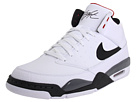

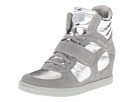

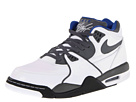

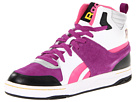

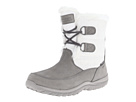

In [ ]:
images = [ PILImage.create(path_images/f) for f in neighbors.path] 
#PILImage.create(btn_upload.data[-1])
for im in images:
    display(im.to_thumb(IMG_SIZE,IMG_SIZE))
          

In [ ]:
#export
def query_neighs(q_feat, myneighs, data, root_path, show = True):
    """
    query feature: (vector)
    myneighs:  fit knn object
    data: series or df containing "path"
    root_path:  path to image files
    """
    distance, nn_index = myneighs.kneighbors(q_feat, return_distance=True)  
    dist = distance.tolist()[0] 

    # fix path to the database...
    neighbors = data.iloc[nn_index.tolist()[0]].copy()
    images = [ PILImage.create(root_path/f) for f in neighbors.path] 
    #PILImage.create(btn_upload.data[-1])
    if show:
        for im in images: display(im.to_thumb(IMG_SIZE,IMG_SIZE))

    return images
        
        

sm
128
features_sm


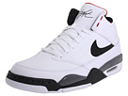

md
160
features_md


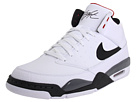

lg
224
features_lg


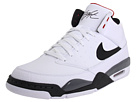

In [ ]:


similar_images = []
for i,sz in enumerate(IMG_SIZES):
    print(ABBR[sz])
    print(IMG_SIZES[sz])
    
    features = f"features_{ABBR[sz]}"
    print(features)

    query_t = load_and_prep_sneaker(path_images/query_image,IMG_SIZES[sz])
    query_f = get_mnet_feature(mnetv2,query_t)
    
    similar_images.append( query_neighs(query_f, knns[i], paths, path_images, show=False) )
     
    im = PILImage.create(path_images/query_image)
    display(im.to_thumb(IMG_SIZES[sz]))



In [ ]:
# export
def plot_sneak_neighs(images):
    ''' function to plot matrix of image urls. 
        image_urls[:,0] should be the query image
        
    Args: 
        images: list of lists
    
    return: 
        null
        saves image file to directory
    '''
    nrow = len(images)
    ncol = len(images[0])
    
    fig = plt.figure(figsize = (20, 20))

    num=0
    for row,image_row in enumerate(images):
        for col,img in enumerate(image_row):
    
            plt.subplot(nrow, ncol, num+1)
            plt.axis('off')
            plt.imshow(img);

            if num%ncol == 0: 
                plt.title('Query')

            if col>0: 
                plt.title('Neighbor ' + str(col))
            num += 1
    plt.savefig('image_search.png')
    plt.show()
        


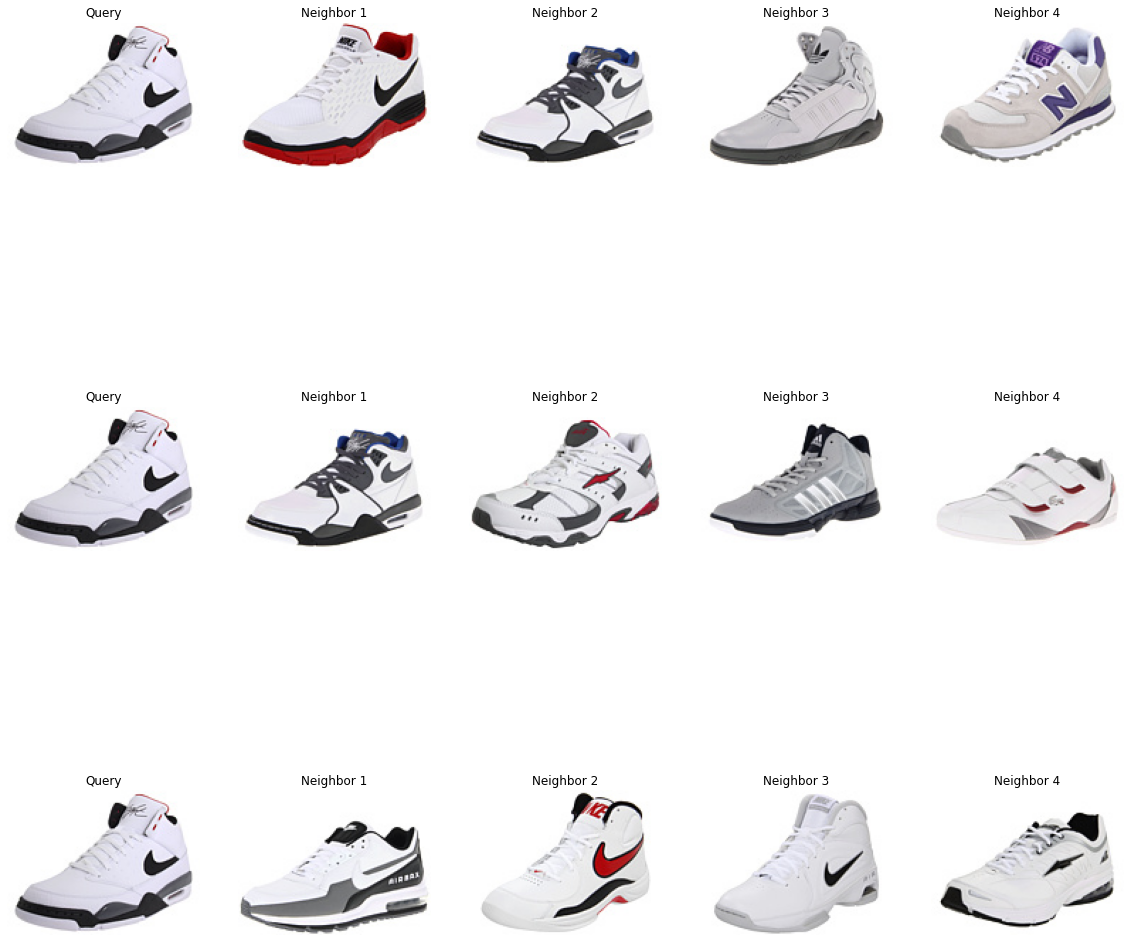

In [ ]:
plot_sneak_neighs(similar_images)


sm
128
features_sm


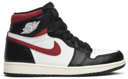

md
160
features_md


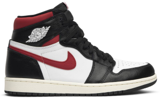

lg
224
features_lg


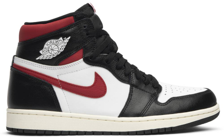

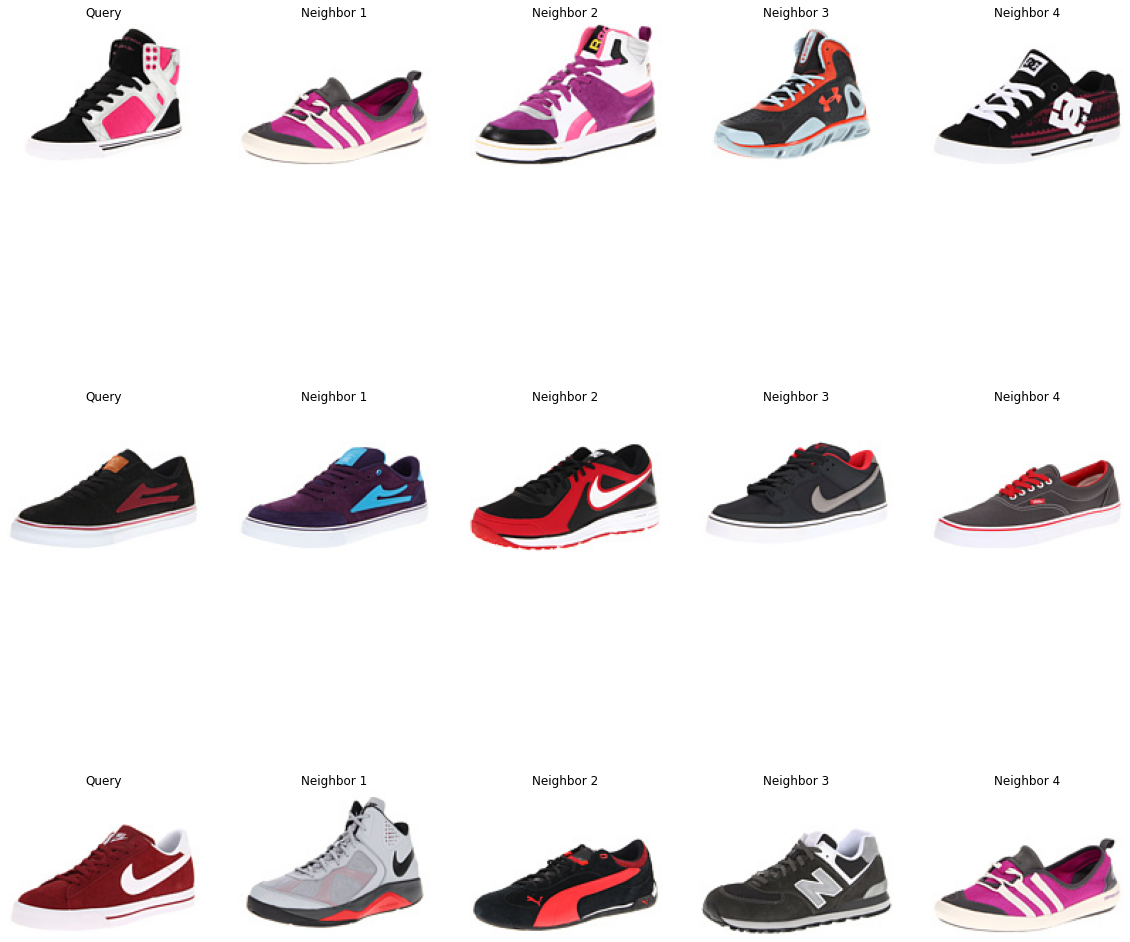

In [ ]:

similar_images2 = []
for i,sz in enumerate(IMG_SIZES):
    print(ABBR[sz])
    print(IMG_SIZES[sz])
    
    features = f"features_{ABBR[sz]}"
    print(features)

    query_t = load_and_prep_sneaker(path_images/query_image2,IMG_SIZES[sz])
    query_f = get_mnet_feature(mnetv2,query_t)
    
    similar_images2.append( query_neighs(query_f, knns[i], paths, path_images, show=False) )

    im = PILImage.create(path_images/query_image2)
    display(im.to_thumb(IMG_SIZES[sz]))
    
plot_sneak_neighs(similar_images2)


# visualize the embedding:  PCA + UMAP

In [ ]:
df.columns

Index(['CID', 'Category', 'path', 'path_and_file', 'Category1', 'Category2',
       'Filename', 'Sneakers', 'Boots', 'Shoes', 'Slippers', 'Adult', 'Gender',
       'train', 'test', 'validate', 't_t_v', 'classes_sm', 'features_sm',
       'classes_md', 'features_md', 'classes_lg', 'features_lg', 'umap-one',
       'umap-two'],
      dtype='object')

sm
128
features_sm
Explained variation per principal component (szsmall): [0.10363452 0.06866893]


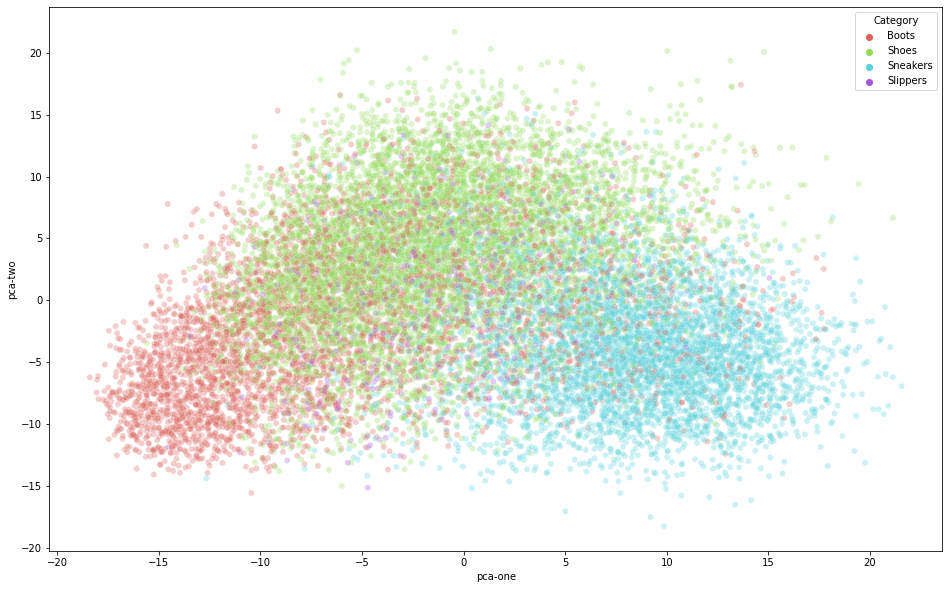

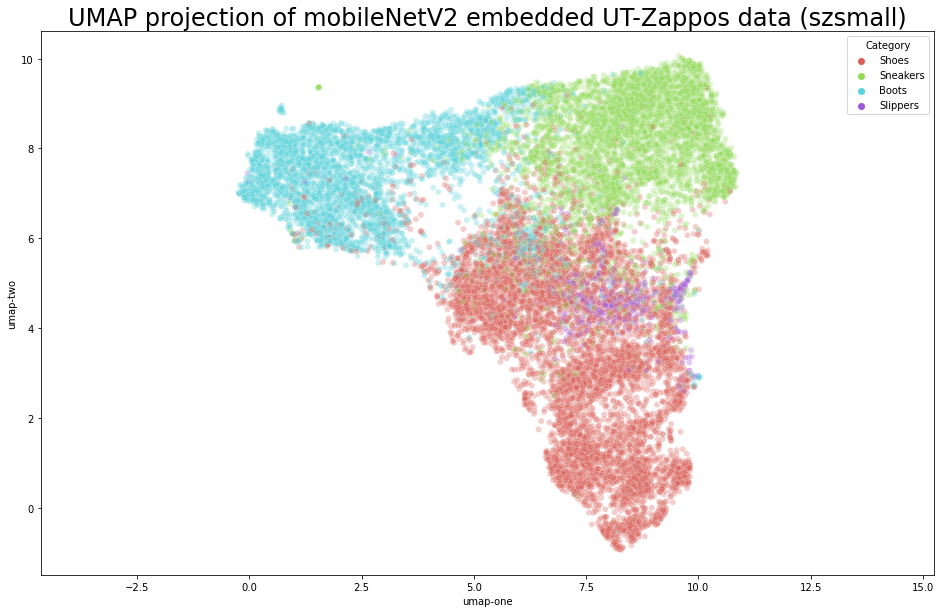

md
160
features_md
Explained variation per principal component (szmedium): [0.10354973 0.07163638]


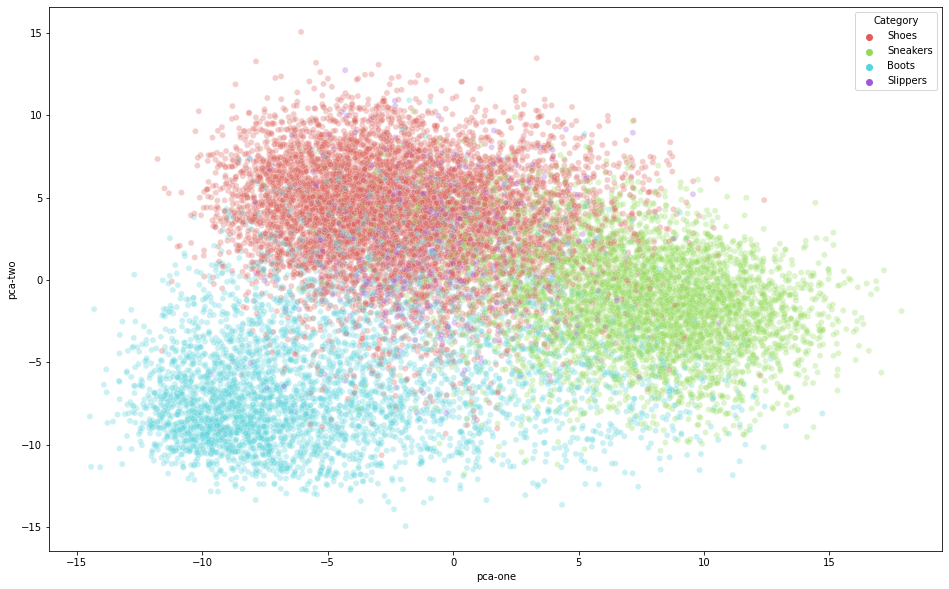

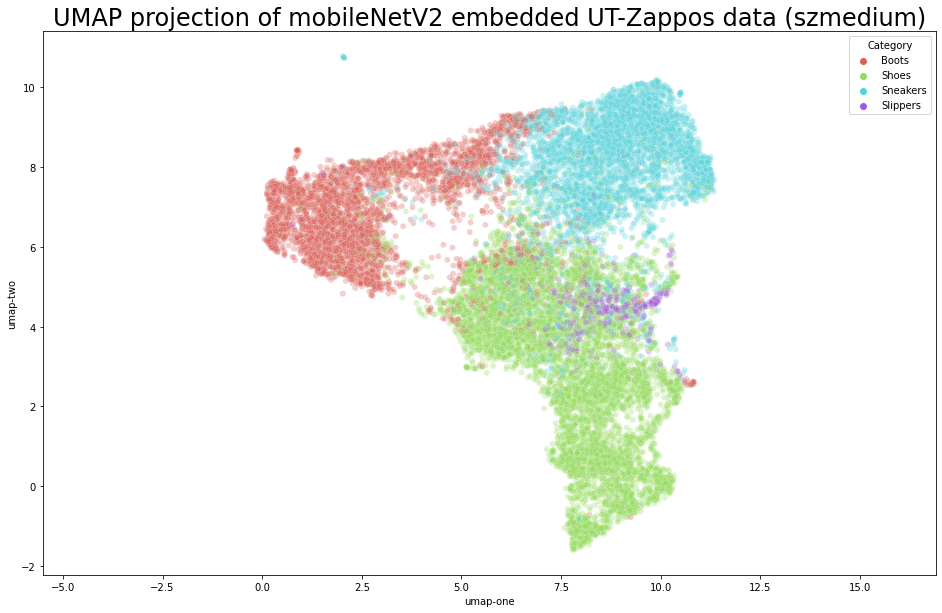

lg
224
features_lg
Explained variation per principal component (szlarge): [0.11955738 0.07852242]


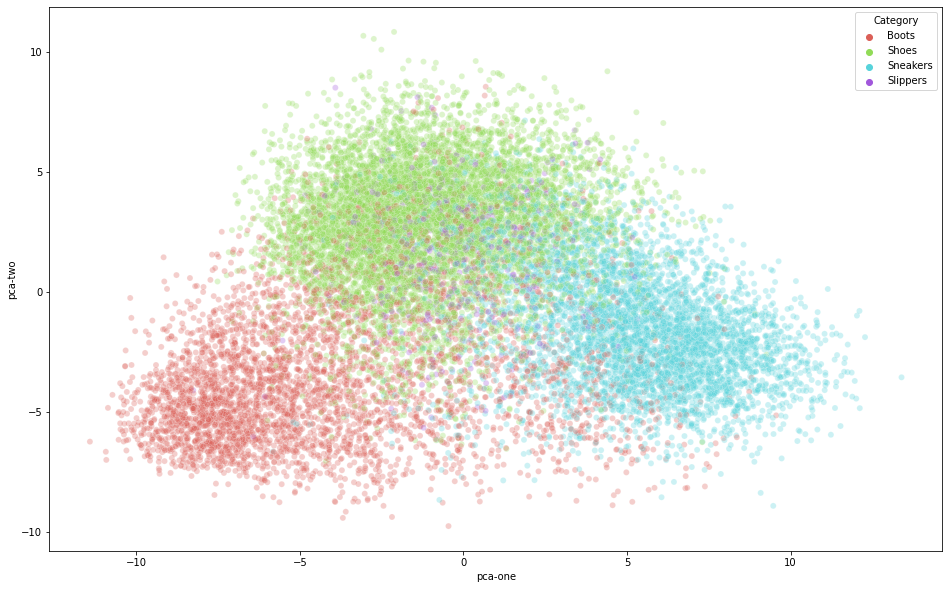

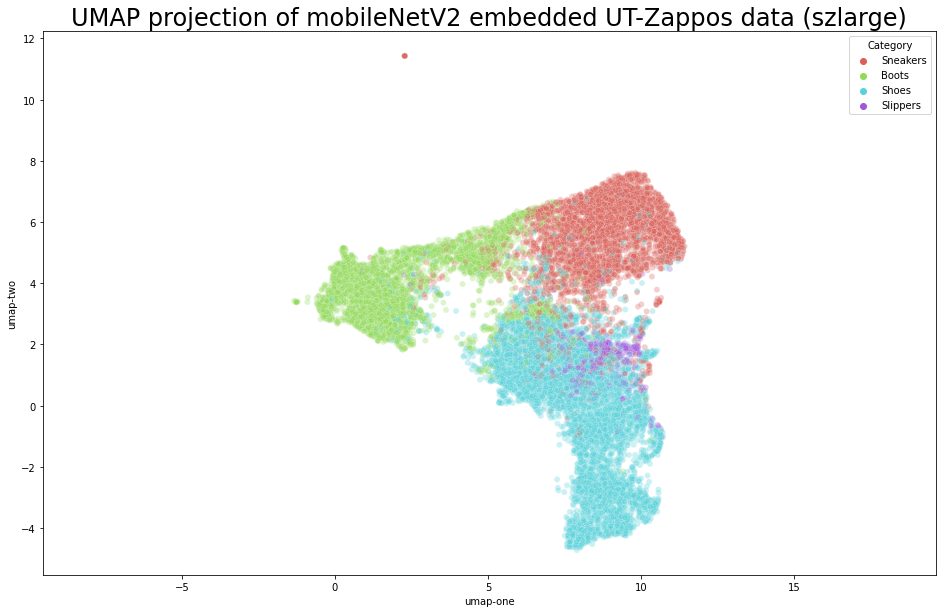

In [ ]:

# first simple PCA
pca = PCA(n_components=2)

for i,sz in enumerate(IMG_SIZES):
    print(ABBR[sz])
    print(IMG_SIZES[sz])
    
    features = f"features_{ABBR[sz]}"
    print(features)
    
    data = df[['Category',features]].copy()

    db_feats = np.vstack(data[features].values)

    # PCA
    pca_result = pca.fit_transform(db_feats)
    data['pca-one'] = pca_result[:,0]
    data['pca-two'] = pca_result[:,1] 
    print(f"Explained variation per principal component (sz{sz}): {pca.explained_variance_ratio_}")

    smpl_fac=.5
    #data=df.reindex(rndperm)

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca-one",
        y="pca-two",
        hue="Category",
        palette=sns.color_palette("hls", 4),
        data=data.sample(frac=smpl_fac),
        legend="full",
        alpha=0.3
    )
    plt.savefig(f'PCA 2-D sz{sz}')
    plt.show()
    
    
    # get the UMAP on deck
    embedding = reducers[i].transform(db_feats)
    
    data['umap-one'] = embedding[:,0]
    data['umap-two'] = embedding[:,1] 

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="umap-one",
        y="umap-two",
        hue="Category",
        palette=sns.color_palette("hls", 4),
        data=data.sample(frac=smpl_fac),
        legend="full",
        alpha=0.3
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of mobileNetV2 embedded UT-Zappos data (sz{sz})', fontsize=24)
    plt.savefig('UMAP 2-D sz{sz}') 
    plt.show()


In [ ]:
# hide
#!pip install umap-learn


In [ ]:
#export
def get_umap_embedding(latents):
    reducer = umap.UMAP(random_state=666)
    reducer.fit(latents)
    embedding = reducer.transform(latents)
    assert(np.all(embedding == reducer.embedding_))
    
    return embedding

In [ ]:
fn = df.path.values
type(db_feats)

snk2vec = dict(zip(fn,db_feats))

snk2vec[list(snk2vec.keys())[0]]

embedding = get_umap_embedding(db_feats)
snk2umap = dict(zip(fn,embedding))
  

In [ ]:

# from sklearn.manifold import TSNE

# cov_mat =np.cov(vects.T)
# plt.figure(figsize=(10,10))
# sns.set(font_scale=1.5)
# hm = sns.heatmap(cov_mat,
#                  cbar=True,
#                  annot=True,
#                  square=True,
#                  fmt='.2f',
#                  annot_kws={'size': 12},
#                  cmap='coolwarm')
# plt.title('Covariance matrix showing correlation coefficients', size = 18)
# plt.tight_layout()
# plt.show()

# now use widgets and make this into a "tool"


In [ ]:
# export

#define my widgets
btn_run = widgets.Button(description='Find k-nearest neighbors')
out_pl = widgets.Output()
lbl_neighs = widgets.Label()
btn_upload = widgets.FileUpload()

def _load_image(im):
    """input: expects a Path(), but string should work, or a Bytestring
    
       returns: resized & squared image
    """
    #image = PILImage.create(btn_upload.data[-1])
    image = PILImage.create(im)
    #BUG: pass split_idx=1 to avoid funny business
    image = Resize(IMG_SIZE, method='pad', pad_mode='border')(image, split_idx=1) 
    return image

def _prep_image(image,to_cuda=False):
    """input: squared/resized PIL image
    
        output TensorImage ready to unsqueeze and "embed"
    TODO:  make this a Pipeline?

    """
    t2 = ToTensor()(image)
    t2 = IntToFloatTensor()(t2)
    t2 = torchvision.transforms.Normalize(*imagenet_stats)(t2)
    
    if to_cuda:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
        
    return t2.to(device)




#img = _load_img(im).flip_lr()
  

def on_click_find_similar(change):
    """ """
    
    im = btn_upload.data[-1]
    
    img = _load_image(im)
    tensor_im = _prep_image(img,to_cuda=False)

    feats = get_mnet_feature(mnetv2, tensor_im )
    distance, nn_index = neighs.kneighbors(feats.numpy(), return_distance=True)    
    dist = distance.tolist()[0] 

    # fix path to the database...
    neighbors = df.iloc[nn_index.tolist()[0]].copy()
    #neighbors.loc[:,'db_path'] = neighbors.loc[:,'path'].astype(str).copy()

    nbr = neighbors.index
    
    
    out_pl.clear_output()
    #with out_pl: display(plot_sneak_neighs(img_row[np.newaxis,:]))  # need to convert to pil...

    
    images = [ PILImage.create(path_images/f) for f in neighbors.path] 

    #PILImage.create(btn_upload.data[-1])
    with out_pl:
        display(img.to_thumb(200,200))
        for i in images:
            display(i.to_thumb(100,100))
       
    lbl_neighs.value = f'distances: {dist}'   

    
btn_run.on_click(on_click_find_similar)




widgets.VBox([widgets.Label('Find your sneaker!'), 
      btn_upload, btn_run, out_pl, lbl_neighs])

In [ ]:
# hide


########## this is WIP
# import re
# import time
# # import matplotlib.pyplot as pltmodel
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import plotly
# import plotly.express as px
# import plotly.figure_factory as FF


import bokeh.plotting as bplt #import figure, show, output_notebook
#from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
import bokeh
# from bokeh.palettes import Spectral10

import umap

#from scipy import spatial  #for now just brute force to find neighbors
import scipy 
#from scipy.spatial import distance

from io import BytesIO
import base64



########################################3
#  BOKEH
#
##########################################3
def init_bokeh_plot(umap_df):

    bplt.output_notebook()

    datasource = bokeh.models.ColumnDataSource(umap_df)
    color_mapping = bokeh.models.CategoricalColorMapper(factors=["sns","goat"],
                                        palette=bokeh.palettes.Spectral10)

    plot_figure = bplt.figure(
        title='UMAP projection VAE latent',
        plot_width=1000,
        plot_height=1000,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(bokeh.models.HoverTool(tooltips="""
    <div>
        <div>
            <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
        </div>
        <div>
            <span style='font-size: 14px'>@fname</span>
            <span style='font-size: 14px'>@loss</span>
        </div>
    </div>
    """))

    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field='db', transform=color_mapping),
        line_alpha=0.6,
        fill_alpha=0.6,
        size=4
    )

    return plot_figure


def embeddable_image(label):
    return image_formatter(label)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((64, 64), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f"data:image/png;base64,{image_base64(im)}"



# do we need it loaded... it might be fast enough??
#@st.cache
def load_UMAP_data():
    data_dir = f"data/{model_name}-X{params['x_dim'][0]}-Z{params['z_dim']}"
    load_dir = os.path.join(data_dir,f"kl_weight{int(params['kl_weight']):03d}")
    snk2umap = ut.load_pickle(os.path.join(load_dir,"snk2umap.pkl"))
    
    return snk2umap


def load_latent_data():
    data_dir = f"data/{model_name}-X{params['x_dim'][0]}-Z{params['z_dim']}"
    snk2umap = load_UMAP_data()

    # load df (filenames and latents...)

    mids = list(snk2vec.keys())
    vecs = np.array([snk2vec[m] for m in mids])
    vec_tree = scipy.spatial.KDTree(vecs)


    latents = np.array(list(snk2vec.values()))
    losses = np.array(list(snk2loss.values()))
    labels = np.array(mids)

    labels2 = np.array(list(snk2umap.keys()))
    embedding = np.array(list(snk2umap.values()))

    assert(np.all(labels == labels2))    
    umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

    umap_df['digit'] = [str(x.decode()) for x in labels]
    umap_df['image'] = umap_df.digit.map(lambda f: embeddable_image(f))
    umap_df['fname'] = umap_df.digit.map(lambda x: f"{x.split('/')[-3]} {x.split('/')[-1]}")
    umap_df['db'] = umap_df.digit.map(lambda x: f"{x.split('/')[-3]}")
    umap_df['loss'] = [f"{x:.1f}" for x in losses]

    return umap_df,snk2vec,latents, labels, vecs,vec_tree,mids


#%%


In [ ]:
# pca = PCA(n_components=10)
# pca_result = pca.fit_transform(df['feats'].values.tolist())
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


# #data=df.sample(frac=1.0)
# #data=df.reindex(rndperm)
# data = df

# #df_subset = df

# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(db_feats)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))



# df['tsne-2d-one'] = tsne_results[:,0]
# df['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="CategoryDir",
#     palette=sns.color_palette("hls", 4),
#     data=df,
#     legend="full",
#     alpha=0.3
#)

## logisic regression on the mobilnet_v2 features

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[1197   25    3   36]
 [  31 2066   13   59]
 [   5   30  100    5]
 [  26   71    2 1316]]


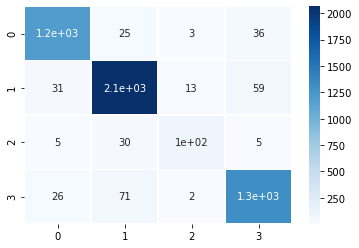

<Figure size 1152x1152 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.linear_model import LogisticRegression
    
#Display Confusion Matrix
X_test = np.vstack(df[df.t_t_v=='test']['features_lg'])
y_test = np.vstack(df[df.t_t_v=='test']['Category']).flatten()

# use validate and train for training (no validation here)
X_train = np.vstack(df[df.train | df.validate]['features_lg'])
y_train = np.vstack(df[df.train | df.validate]['Category']).flatten()


clf_log = LogisticRegression(C = 1, multi_class='ovr', max_iter=2000, solver='lbfgs')
clf_log.fit(X_train, y_train)
log_score = clf_log.score(X_test, y_test)
log_ypred = clf_log.predict(X_test)

log_confusion_matrix = confusion_matrix(y_test, log_ypred)
print(log_confusion_matrix)

disp = heatmap(log_confusion_matrix, annot=True, linewidths=0.5, cmap='Blues')
plt.savefig('log_Matrix.png')


plt.figure(figsize=(16,16))


# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

Confusion matrix, without normalization
[[1197   25    3   36]
 [  31 2066   13   59]
 [   5   30  100    5]
 [  26   71    2 1316]]
Normalized confusion matrix
[[0.94924663 0.01982554 0.00237906 0.02854877]
 [0.0142923  0.95251268 0.00599355 0.02720148]
 [0.03571429 0.21428571 0.71428571 0.03571429]
 [0.01837456 0.05017668 0.00141343 0.93003534]]


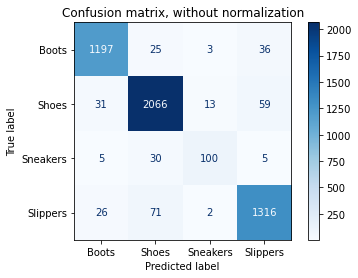

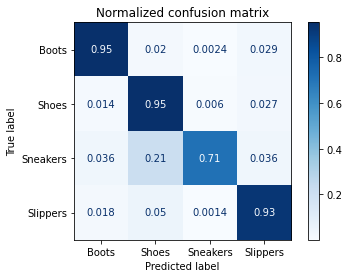

In [ ]:
class_names = df.Category.unique()

from sklearn.metrics import plot_confusion_matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_log, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('log_Matrix2.png')

In [ ]:
# 

In [ ]:


from nbdev.export import notebook2script
notebook2script()



Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02a_model.ipynb.
Converted 03_model.ipynb.
Converted index.ipynb.
